In [1]:
import torch
import torchphysics as tp
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')
URMS = tp.spaces.R1('urms')
VRMS = tp.spaces.R1('vrms')
UV=tp.spaces.R1('uv')
P=tp.spaces.R1('p')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np

In [3]:
class Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        P_xtrain=tp.spaces.Points([self.x_train[idx]],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([self.y_train[idx]],U*V*URMS*VRMS*UV,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [4]:
class Ho_Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list,horizon_sampler,Nsamples=30):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        self.sampler=horizon_sampler
        self.N_iter=Nsamples
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        if idx>self.N_iter:
            raise StopIteration
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        x_horizon= self.sampler.sample_points(device="cpu")
        x_horizon,_=x_horizon.track_coord_gradients()
        x_horizon=x_horizon["x"].detach().numpy()
        #print(x_horizon)
        idx_local=np.random.randint(0,len(self.y_train)-1)
        y_new=np.broadcast_to(self.x_train[idx_local],(x_horizon.shape[0],self.x_train[idx_local].shape[0]))
        target_new=np.broadcast_to(self.y_train[idx_local],(x_horizon.shape[0],self.y_train[idx_local].shape[0]))
        X_points = np.concatenate((x_horizon,y_new),axis=1)
        P_xtrain=tp.spaces.Points([X_points],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([target_new],U*V*URMS*VRMS*UV,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [5]:
class Rn_Turbulent_Data(torch.utils.data.Dataset):
    def __init__(self,data_DF,x_list,y_list,max_it):
        self.x_train=data_DF[x_list].values
        self.y_train=data_DF[y_list].values
        self.length=min(max_it,len(self.y_train))
        #self.x_train=torch.tensor(x_train,dtype=torch.float32)
        #self.y_train=torch.tensor(y_train,dtype=torch.float32)
        #self.x_train=tp.spaces.Points(self.x_train,X*Y)
        #self.y_train=tp.spaces.Points(self.y_train,U*V)
    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        #return self.x_train[idx] , self.y_train[idx]
        #print(torch.as_tensor([self.x_train[idx]]).shape)
        id_random=random.randint(0,len(self.y_train))
        P_xtrain=tp.spaces.Points([self.x_train[id_random]],X*Y,dtype=torch.float32)
        P_ytrain=tp.spaces.Points([self.y_train[id_random]],U*V*URMS*VRMS*UV,dtype=torch.float32)
        return P_xtrain,P_ytrain

In [6]:
DF_Data=pd.read_csv("Data/irr_turb_1113.csv")

In [7]:
DF=DF_Data#[0:226:5]

In [8]:
DF

,x,y,U,V,W,urms,vrms,wrms,uv,uw,vw
0,0,0.000000,-3.607400e-16,1.613000e-34,-9.713800e-19,3.418200e-14,1.150800e-16,1.413000e-15,-3.887400e-34,-2.919100e-32,-4.974300e-35
1,0,0.000024,3.335700e-07,-4.846800e-28,-2.065500e-10,6.489700e-05,2.238200e-08,4.605300e-05,2.097400e-15,3.653000e-12,-7.126600e-17
2,0,0.000097,1.014300e-06,1.809500e-25,-6.637900e-10,2.539900e-04,3.782400e-07,1.802100e-04,8.371800e-14,5.502000e-11,-6.556900e-15
3,0,0.000219,1.301300e-06,2.068000e-26,-1.835200e-09,5.527400e-04,1.742400e-06,3.920100e-04,8.807500e-13,2.636100e-10,-6.286700e-14
4,0,0.000390,1.512500e-06,1.089100e-24,-2.318100e-09,9.382500e-04,5.342600e-06,6.651500e-04,2.350800e-12,7.605200e-10,-3.676700e-13
...,...,...,...,...,...,...,...,...,...,...,...
446,0,1.999600,1.524500e-06,-1.233900e-24,-5.765600e-09,9.777800e-04,5.601300e-06,7.018700e-04,-3.290100e-12,2.495400e-10,1.632200e-13
447,0,1.999800,1.300100e-06,-1.426900e-24,-3.328300e-09,5.760100e-04,1.826900e-06,4.136400e-04,-1.102500e-12,8.272700e-11,2.622500e-14
448,0,1.999900,1.017600e-06,-2.429800e-25,-1.578500e-09,2.646700e-04,3.964100e-07,1.901600e-04,-1.064100e-13,1.645000e-11,4.125400e-15
449,0,2.000000,3.336400e-07,3.715900e-27,-3.850700e-10,6.762800e-05,2.346900e-08,4.859300e-05,-2.507200e-15,1.045800e-12,1.709800e-17


In [9]:
import random
def Augment_1D_data(DF,Nsampler,L_x):
    DF_out=DF[0:0]
    for _ in range(Nsampler):
        Ny=random.randint(0, len(DF)-1)
        DF_temp=DF.iloc[[Ny]]
        DF_temp["x"]=random.uniform(0,L_x)
        DF_out=pd.concat([DF_out,DF_temp],ignore_index=True)
    return DF_out

        

In [10]:
torch.cuda.device_count()

0

In [11]:
X_interval = tp.domains.Interval(X, 0, 2.4) # <-add the bounds of the Interval (0, 2)
Y_interval = tp.domains.Interval(Y, 0, 2.0)
Sim_domain = X_interval*Y_interval


In [12]:
DF_out=Augment_1D_data(DF_Data,8000,2.0)
ho_sampler = tp.samplers.RandomUniformSampler(X_interval, n_points=200)
dataset_turbulent=Ho_Turbulent_Data(DF,["y"],["U","V","urms","vrms","uv"],ho_sampler,30)

/tmp/ipykernel_3866503/1272658583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_temp["x"]=random.uniform(0,L_x)


In [13]:

bound_sampler_low = tp.samplers.RandomUniformSampler(Y_interval.boundary_left*X_interval, n_points=250)

bound_sampler_up = tp.samplers.RandomUniformSampler(X_interval*Y_interval.boundary, n_points=500)


In [14]:
DF_DIST=pd.read_csv("Data/DIST_1113.csv")

In [15]:
x_corr=DF_DIST["x"].to_numpy()
x_corr=torch.tensor(x_corr,requires_grad=False)
dist=DF_DIST["dist"].to_numpy()
dist=torch.tensor(dist,requires_grad=False)

In [16]:
def IBM_irr_filter(x,y):
    position_r=np.array([sum(x_corr<x_i)-1 for x_i in x])
    #position_r=sum(x_corr<x)
    position_l=position_r-1
    height=dist[position_l]+(dist[position_r]-dist[position_l])*(x-x_corr[position_l])/(x_corr[position_r]-x_corr[position_l])
    return (y[...,0]<=height)|(y[...,0]>=2-height)   
IBM_sampler_irr = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_irr_filter)

In [17]:
def IBM_filter(x,y):
    return y[...,0]<=torch.sin(x[...,0]*np.pi*2)*0.1    
IBM_sampler = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter)

In [18]:
def IBM_filter_2(y):
    return (y[...,0]<0)&(y[...,0]>-0.1)
    
IBM_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter_2)

In [19]:
def Inner_filter(y):
    position_r=np.array([sum(x_corr<x_i)-1 for x_i in x])
    #position_r=sum(x_corr<x)
    position_l=position_r-1
    print(x,position_r,position_l)
    height=dist[position_l]+(dist[position_r]-dist[position_l])*(x-x_corr[position_l])/(x_corr[position_r]-x_corr[position_l])
    return (y[...,0]>height) |(y[...,0]<2-height)   
inner_sampler = tp.samplers.RandomUniformSampler(Sim_domain, n_points=2000)#,filter_fn=Inner_filter)

In [20]:

class self_Sin(torch.nn.Module):

  def forward(self, x):
    return torch.sin(x)
model = tp.models.FCN(input_space=X*Y, output_space=U*V*URMS*VRMS*UV*P, hidden=(8,16,32,64,64,32,16),activations=tp.models.Sinus())#######Activation????

In [21]:
data_cond = tp.conditions.DataCondition_mean(model, dataset_turbulent, norm=2.0,root=1.0,weight=500,use_full_dataset=True,name='Data')

In [22]:
inte_sampler = tp.samplers.RandomUniformSampler(X_interval.boundary*Y_interval, n_points=250)
x_inlet_sampler=tp.samplers.RandomUniformSampler(X_interval*Y_interval,n_points=250)

In [23]:
def init_bulk(u_integral):
    return u_integral-1
pde_cond_bulk=tp.conditions.IntegroPINNCondition(model,x_inlet_sampler,init_bulk,inte_sampler, weight=1)

In [24]:
def pde_IBM(u,v,urms,vrms,uv):
    return torch.abs(u)+torch.abs(v)+torch.abs(urms)+torch.abs(vrms)+torch.abs(uv)
pde_cond_IBM = tp.conditions.PINNCondition(model, IBM_sampler_irr, pde_IBM,weight=10,name='IBM')

In [25]:
def pde_IBM_2(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM_2 = tp.conditions.PINNCondition(model, IBM_sampler_2, pde_IBM_2,weight=10,name='IBM_2')

In [26]:
def pde_IBM_p(p):
    return p
pde_cond_IBM_p = tp.conditions.PINNCondition(model, IBM_sampler_irr, pde_IBM_p,weight=10,name='IBM_p')

In [27]:
def pde_mass(u,v,x,y):
    return tp.utils.grad(u,x)+tp.utils.grad(v,y)-0.0
pde_cond_mass = tp.conditions.PINNCondition(model, inner_sampler,pde_mass, weight=10,name='Conti')

In [28]:
def pde_residual_x(u,v, x, y,urms,vrms,uv,p):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/6000 + 0.02336+tp.utils.grad(torch.square(urms),x)+tp.utils.grad(uv,y)+tp.utils.grad(p,x)
    return residual_momentum

pde_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_x, pde_IBM,weight=50,name='Momentum_x')

In [29]:
def pde_residual_y(u,v, x, y,urms,vrms,uv,p):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/6000+tp.utils.grad(uv,x)+tp.utils.grad(torch.square(vrms),y)+tp.utils.grad(p,y)
    return residual_momentum

pde_cond_y = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_y, pde_IBM,weight=50,name='Momentum_y')

In [30]:
def boundary_residual_x(u, x,y):
    return torch.square(u) - 0.0

boundary_cond_x = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_x, weight=1,name='noslip_x')

In [31]:
def boundary_residual_y(v, x,y):
    return torch.square(v) - 0.0

boundary_cond_y = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_y, weight=1,name='noslip_y')

In [32]:
def boundary_residual_uu(urms, x,y):
    return torch.square(urms) - 0.0

boundary_cond_uu = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_uu, weight=1,name='noslip_x_uu')

In [33]:
def boundary_residual_vv(vrms, x,y):
    return torch.square(vrms) - 0.0

boundary_cond_vv = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_vv, weight=1,name='noslip_x_vv')

In [34]:
def boundary_residual_uv(uv, x,y):
    return uv - 0.0

boundary_cond_uv = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_uv, weight=1,name='noslip_x_uv')

In [35]:

Periodic_sampler=tp.samplers.RandomUniformSampler(Y_interval,n_points=250)#,filter_fn=Inner_filter)

In [36]:
def periodic_residual_x(u_left,u_right):
    Periodic_condition= u_left - u_right
    return Periodic_condition
periodic_cond_x=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_x,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_x')

In [37]:
def periodic_residual_y(v_left,v_right):
    Periodic_condition= v_left - v_right
    return Periodic_condition
periodic_cond_y=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_y,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_y')

In [38]:
def periodic_residual_uu(urms_left,urms_right):
    Periodic_condition= urms_left - urms_right
    return Periodic_condition
periodic_cond_uu=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_uu,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_uu')

In [39]:
def periodic_residual_vv(vrms_left,vrms_right):
    Periodic_condition= vrms_left - vrms_right
    return Periodic_condition
periodic_cond_vv=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_vv,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_vv')

In [40]:
def periodic_residual_uv(uv_left,uv_right):
    Periodic_condition= uv_left - uv_right
    return Periodic_condition
periodic_cond_uv=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_uv,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_uv')

In [41]:
def periodic_residual_p(p_left,p_right):
    Periodic_condition= p_left-p_right
    return Periodic_condition
periodic_cond_p=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_p,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_p')

In [42]:
bound_sampler_left = tp.samplers.RandomUniformSampler(X_interval.boundary_left*Y_interval, n_points=250)
def boundary_residual_p(p, x,y):
    return p

boundary_cond_p = tp.conditions.PINNCondition(model, bound_sampler_left, boundary_residual_p, weight=1,name='bound_p')

In [43]:
##Learning rate scheduling To-Do -- launch LR scheduling only after first training phase
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001,scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,scheduler_args={"patience":1000,"factor":0.8,"verbose":True,"min_lr":0.000005},monitor_lr="train/loss")
#solver = tp.solver.Solver([pde_cond_IBM,pde_cond_mass,boundary_cond_x, pde_cond_x,periodic_cond_x,boundary_cond_y, pde_cond_y,periodic_cond_y], optimizer_setting=optim)
##loss terms scheduling
solver = tp.solver.Solver([pde_cond_IBM,#1000
                           pde_cond_IBM_p,
                           #pde_cond_IBM_2,#1000
                            data_cond,
                           boundary_cond_x,#1000
                           boundary_cond_y,
                           boundary_cond_uu,#1000
                           boundary_cond_vv,
                           boundary_cond_uv,
                           #boundary_cond_p,
                           periodic_cond_x,#2000
                           periodic_cond_y,
                           periodic_cond_uu,#2000
                           periodic_cond_vv,
                           periodic_cond_uv,
                           periodic_cond_p,
                           pde_cond_x,#5000
                           pde_cond_y,#5000
                           pde_cond_mass],#1000
                          optimizer_setting=optim,
                         loss_function_schedule=[{
                        "conditions":list(range(17)),
                        "max_iter":15000
                    },
                     {
                        "conditions":list(range(17)),
                        "max_iter":20000
                    }
                ],
                          weight_tunning=True,
                          weight_tunning_parameters={
                                    "alfa":0.99,
                                    "E_rho":0.99,
                                    "Temperature":0.1,
                                    "tunning_every_n_steps":100
                          } ## Default weight-tunning settings
                         )

In [44]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
torch.set_float32_matmul_precision('medium')
comet_logger = pl_loggers.CSVLogger(save_dir="logs/")
trainer = pl.Trainer(gpus=0,# use one GPU
                     max_steps=30000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=comet_logger, # for writting into tensorboard
                     log_every_n_steps=100,
                     enable_checkpointing=False) # saving checkpoints ToDo: turn on checkpointing after first training phase
trainer.fit(solver)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:273: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'verbose', 'factor', 'patience', 'min_lr'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 9.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
9.7 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                            | 0/30001 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchphysics/problem/spaces/points.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self._t = torch.as_tensor(data, **kwargs)


Epoch 0: 100%|██████████████████████▉| 30000/30001 [56:08:14<00:06,  6.74s/it, loss=9.95, v_num=132]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████| 30001/30001 [56:08:14<00:00,  6.74s/it, loss=9.95, v_num=132]

`Trainer.fit` stopped: `max_steps=30000` reached.


Epoch 0: 100%|███████████████████████| 30001/30001 [56:08:14<00:00,  6.74s/it, loss=9.95, v_num=132]


In [45]:
import numpy as np

In [46]:
import matplotlib.pyplot as plt

In [47]:
plt.close()

In [48]:
def produce_sample(x_max,y_max,other_Constrains,resolution=100):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(0,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)    
    model_value_urms=np.zeros(XM.shape)
    model_value_p=np.zeros(XM.shape)
    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j]]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,1]
            model_value_urms[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,2]
            model_value_p[i,j] = model(tp.spaces.Points(coords, X*Y)).as_tensor[0,5]
    model_value_x=np.transpose(model_value_x)
    model_value_y=np.transpose(model_value_y)
    model_value_p=np.transpose(model_value_p)
    plt.contourf(XM,YM,model_value_x)
    
    plt.colorbar()
    plt.plot(x_corr,dist)
    return model_value_x


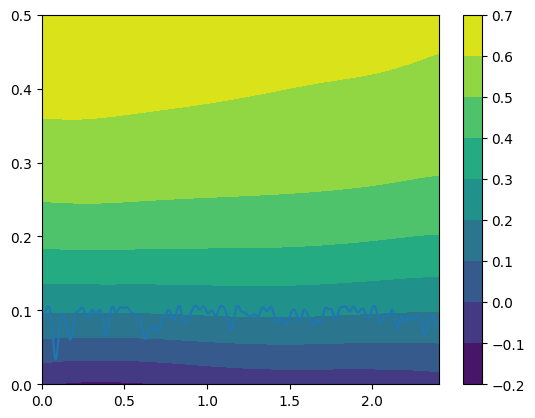

In [60]:
model_values=produce_sample(2.4,0.5,500)


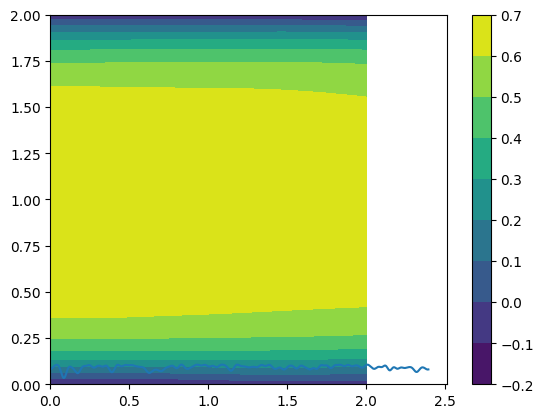

In [50]:
model_values=produce_sample(2,2,100)


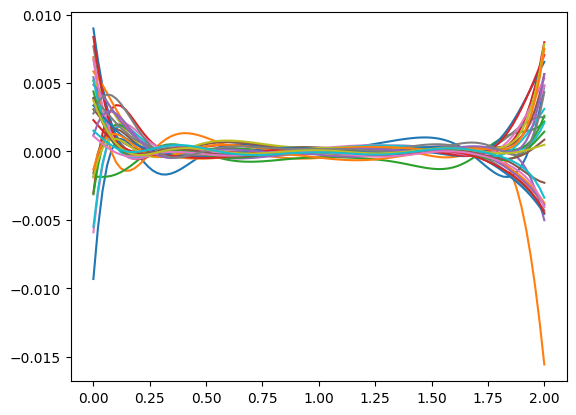

In [51]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
    for k in range(2,5):
        plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

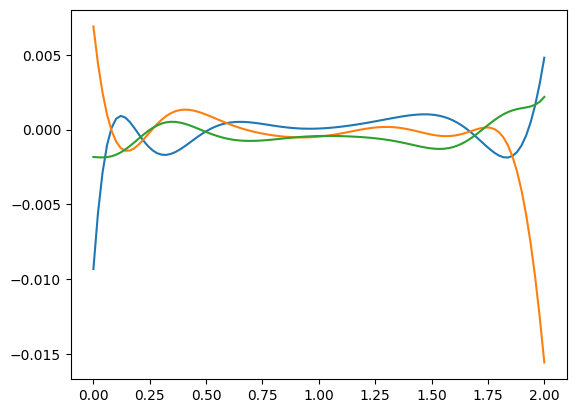

In [52]:
coords = torch.tensor([[0,i] for i in np.linspace(0,2,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(2,5):
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

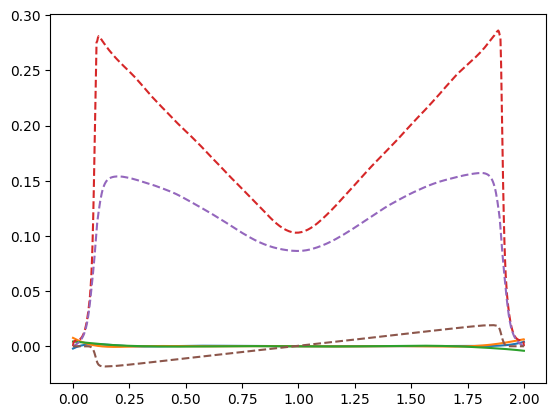

In [53]:
coords = torch.tensor([[1,i] for i in DF_Data["y"]], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(2,5):
    plt.plot(DF_Data["y"],np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])
plt.plot(DF_Data["y"],DF_Data["urms"],'--')
plt.plot(DF_Data["y"],DF_Data["vrms"],'--')
plt.plot(DF_Data["y"],DF_Data["uv"],'--')

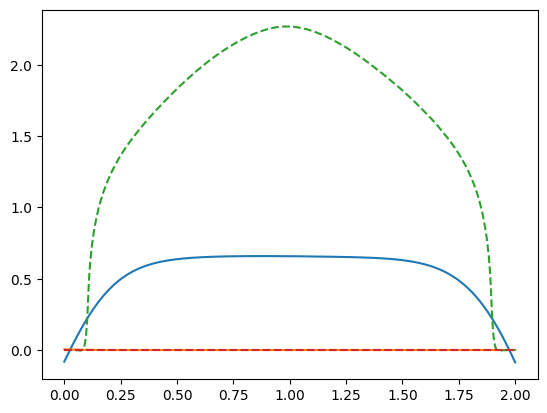

In [54]:
coords = torch.tensor([[1,i] for i in DF_Data["y"]], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(0,2):
    plt.plot(DF_Data["y"],np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])
plt.plot(DF_Data["y"],DF_Data["U"],'--')
plt.plot(DF_Data["y"],DF_Data["V"],'--')


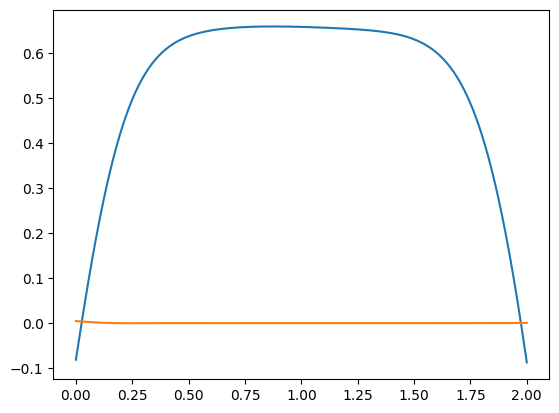

In [55]:
coords = torch.tensor([[1,i] for i in DF_Data["y"]], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
for k in range(0,2):
    plt.plot(DF_Data["y"],np.array(model_out.transpose(0,1)[k].tolist()))
    #plt.plot([0.4,0.4],[0.1,-0.1])

In [56]:
DF_Data

,x,y,U,V,W,urms,vrms,wrms,uv,uw,vw
0,0,0.000000,-3.607400e-16,1.613000e-34,-9.713800e-19,3.418200e-14,1.150800e-16,1.413000e-15,-3.887400e-34,-2.919100e-32,-4.974300e-35
1,0,0.000024,3.335700e-07,-4.846800e-28,-2.065500e-10,6.489700e-05,2.238200e-08,4.605300e-05,2.097400e-15,3.653000e-12,-7.126600e-17
2,0,0.000097,1.014300e-06,1.809500e-25,-6.637900e-10,2.539900e-04,3.782400e-07,1.802100e-04,8.371800e-14,5.502000e-11,-6.556900e-15
3,0,0.000219,1.301300e-06,2.068000e-26,-1.835200e-09,5.527400e-04,1.742400e-06,3.920100e-04,8.807500e-13,2.636100e-10,-6.286700e-14
4,0,0.000390,1.512500e-06,1.089100e-24,-2.318100e-09,9.382500e-04,5.342600e-06,6.651500e-04,2.350800e-12,7.605200e-10,-3.676700e-13
...,...,...,...,...,...,...,...,...,...,...,...
446,0,1.999600,1.524500e-06,-1.233900e-24,-5.765600e-09,9.777800e-04,5.601300e-06,7.018700e-04,-3.290100e-12,2.495400e-10,1.632200e-13
447,0,1.999800,1.300100e-06,-1.426900e-24,-3.328300e-09,5.760100e-04,1.826900e-06,4.136400e-04,-1.102500e-12,8.272700e-11,2.622500e-14
448,0,1.999900,1.017600e-06,-2.429800e-25,-1.578500e-09,2.646700e-04,3.964100e-07,1.901600e-04,-1.064100e-13,1.645000e-11,4.125400e-15
449,0,2.000000,3.336400e-07,3.715900e-27,-3.850700e-10,6.762800e-05,2.346900e-08,4.859300e-05,-2.507200e-15,1.045800e-12,1.709800e-17


In [57]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,20] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

NameError: name 'H' is not defined

In [ ]:
coords = torch.tensor([[5,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))
coords = torch.tensor([[0,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))